In [1]:
""" 最初のモデル構築 -->Score: 0.13432
    auther:  ryoma yokoyama
    created: 2025.05.01 10:30:51
"""

import os
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import tqdm
from hydra import compose, initialize
from omegaconf import OmegaConf

from src.seed import seed_everything

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config.yaml")
    cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


exp_number: '000'
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/000
seed: 42
n_splits: 5
target: SalePrice



In [2]:
train_df = pl.read_csv(cfg.data.train_path, infer_schema_length=10_000)
test_df = pl.read_csv(cfg.data.test_path, infer_schema_length=10_000)

print("■ train")
display(train_df.head())
print("■ test")
display(test_df.head())

print("■ train")
display(train_df.describe())
print(train_df.dtypes)
print(f"行数: {train_df.shape[0]}, 列数: {train_df.shape[1]}")

print("\n■ test")
display(test_df.describe())
print(test_df.dtypes)
print(f"行数: {test_df.shape[0]}, 列数: {test_df.shape[1]}")


■ train


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,…,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
i64,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,str,str,str,i64,i64,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,str,str,i64
1,60,"""RL""","""65""",8450,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""CollgCr""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,2003,2003,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""196""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""No""","""GLQ""",706,"""Unf""",0,…,854,0,1710,1,0,2,1,3,1,"""Gd""",8,"""Typ""",0,"""NA""","""Attchd""","""2003""","""RFn""",2,548,"""TA""","""TA""","""Y""",0,61,0,0,0,0,"""NA""","""NA""","""NA""",0,2,2008,"""WD""","""Normal""",208500
2,20,"""RL""","""80""",9600,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""FR2""","""Gtl""","""Veenker""","""Feedr""","""Norm""","""1Fam""","""1Story""",6,8,1976,1976,"""Gable""","""CompShg""","""MetalSd""","""MetalSd""","""None""","""0""","""TA""","""TA""","""CBlock""","""Gd""","""TA""","""Gd""","""ALQ""",978,"""Unf""",0,…,0,0,1262,0,1,2,0,3,1,"""TA""",6,"""Typ""",1,"""TA""","""Attchd""","""1976""","""RFn""",2,460,"""TA""","""TA""","""Y""",298,0,0,0,0,0,"""NA""","""NA""","""NA""",0,5,2007,"""WD""","""Normal""",181500
3,60,"""RL""","""68""",11250,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""CollgCr""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,2001,2002,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""162""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""Mn""","""GLQ""",486,"""Unf""",0,…,866,0,1786,1,0,2,1,3,1,"""Gd""",6,"""Typ""",1,"""TA""","""Attchd""","""2001""","""RFn""",2,608,"""TA""","""TA""","""Y""",0,42,0,0,0,0,"""NA""","""NA""","""NA""",0,9,2008,"""WD""","""Normal""",223500
4,70,"""RL""","""60""",9550,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""Crawfor""","""Norm""","""Norm""","""1Fam""","""2Story""",7,5,1915,1970,"""Gable""","""CompShg""","""Wd Sdng""","""Wd Shng""","""None""","""0""","""TA""","""TA""","""BrkTil""","""TA""","""Gd""","""No""","""ALQ""",216,"""Unf""",0,…,756,0,1717,1,0,1,0,3,1,"""Gd""",7,"""Typ""",1,"""Gd""","""Detchd""","""1998""","""Unf""",3,642,"""TA""","""TA""","""Y""",0,35,272,0,0,0,"""NA""","""NA""","""NA""",0,2,2006,"""WD""","""Abnorml""",140000
5,60,"""RL""","""84""",14260,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""FR2""","""Gtl""","""NoRidge""","""Norm""","""Norm""","""1Fam""","""2Story""",8,5,2000,2000,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""350""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""Av""","""GLQ""",655,"""Unf""",0,…,1053,0,2198,1,0,2,1,4,1,"""Gd""",9,"""Typ""",1,"""TA""","""Attchd""","""2000""","""RFn""",3,836,"""TA""","""TA""","""Y""",192,84,0,0,0,0,"""NA""","""NA""","""NA""",0,12,2008,"""WD""","""Normal""",250000


■ test


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,…,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
i64,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,i64,i64,i64,i64,str,str,i64,i64,i64,i64,str,i64,str,i64,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,i64,str,str
1461,20,"""RH""","""80""",11622,"""Pave""","""NA""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""None""","""0""","""TA""","""TA""","""CBlock""","""TA""","""TA""","""No""","""Rec""","""468""","""LwQ""","""144""",…,896,0,0,896,"""0""","""0""",1,0,2,1,"""TA""",5,"""Typ""",0,"""NA""","""Attchd""","""1961""","""Unf""","""1""","""730""","""TA""","""TA""","""Y""",140,0,0,0,120,0,"""NA""","""MnPrv""","""NA""",0,6,2010,"""WD""","""Normal"""
1462,20,"""RL""","""81""",14267,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""BrkFace""","""108""","""TA""","""TA""","""CBlock""","""TA""","""TA""","""No""","""ALQ""","""923""","""Unf""","""0""",…,1329,0,0,1329,"""0""","""0""",1,1,3,1,"""Gd""",6,"""Typ""",0,"""NA""","""Attchd""","""1958""","""Unf""","""1""","""312""","""TA""","""TA""","""Y""",393,36,0,0,0,0,"""NA""","""NA""","""Gar2""",12500,6,2010,"""WD""","""Normal"""
1463,60,"""RL""","""74""",13830,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",5,5,1997,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""None""","""0""","""TA""","""TA""","""PConc""","""Gd""","""TA""","""No""","""GLQ""","""791""","""Unf""","""0""",…,928,701,0,1629,"""0""","""0""",2,1,3,1,"""TA""",6,"""Typ""",1,"""TA""","""Attchd""","""1997""","""Fin""","""2""","""482""","""TA""","""TA""","""Y""",212,34,0,0,0,0,"""NA""","""MnPrv""","""NA""",0,3,2010,"""WD""","""Normal"""
1464,60,"""RL""","""78""",9978,"""Pave""","""NA""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",6,6,1998,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""BrkFace""","""20""","""TA""","""TA""","""PConc""","""TA""","""TA""","""No""","""GLQ""","""602""","""Unf""","""0""",…,926,678,0,1604,"""0""","""0""",2,1,3,1,"""Gd""",7,"""Typ""",1,"""Gd""","""Attchd""","""1998""","""Fin""","""2""","""470""","""TA""","""TA""","""Y""",360,36,0,0,0,0,"""NA""","""NA""","""NA""",0,6,2010,"""WD""","""Normal"""
1465,120,"""RL""","""43""",5005,"""Pave""","""NA""","""IR1""","""HLS""","""AllPub""","""Inside""","""Gtl""","""StoneBr""","""Norm""","""Norm""","""TwnhsE""","""1Story""",8,5,1992,1992,"""Gable""","""CompShg""","""HdBoard""","""HdBoard""","""None""","""0""","""Gd""","""TA""","""PConc""","""Gd""","""TA""","""No""","""ALQ""","""263""","""Unf""","""0""",…,1280,0,0,1280,"""0""","""0""",2,0,2,1,"""Gd""",5,"""Typ""",0,"""NA""","""Attchd""","""1992""","""RFn""","""2""","""506""","""TA""","""TA""","""Y""",0,82,0,0,144,0,"""NA""","""NA""","""NA""",0,1,2010,"""WD""","""Normal"""


■ train


statistic,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,…,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
str,f64,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str,f64
"""count""",1460.0,1460.0,"""1460""","""1460""",1460.0,"""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,1460.0,"""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""","""1460""",1460.0,"""1460""",…,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,"""1460""",1460.0,"""1460""",1460.0,"""1460""","""1460""","""1460""","""1460""",1460.0,1460.0,"""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,"""1460""","""1460""","""1460""",1460.0,1460.0,1460.0,"""1460""","""1460""",1460.0
"""null_count""",0.0,0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""",…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",730.5,56.89726,null,null,10516.828082,null,null,null,null,null,null,null,null,null,null,null,null,6.099315,5.575342,1971.267808,1984.865753,null,null,null,null,null,null,null,null,null,null,null,null,null,443.639726,null,…,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,null,6.517808,null,0.613014,null,null,null,null,1.767123,472.980137,null,null,null,94.244521,46.660274,21.95411,3.409589,15.060959,2.758904,null,null,null,43.489041,6.321918,2007.815753,null,null,180921.19589
"""std""",421.610009,42.300571,null,null,9981.264932,null,null,null,null,null,null,null,null,null,null,null,null,1.382997,1.112799,30.202904,20.645407,null,null,null,null,null,null,null,null,null,null,null,null,null,456.098091,null,…,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,null,1.625393,null,0.644666,null,null,null,null,0.747315,213.804841,null,null,null,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,null,null,null,496.123024,2.703626,1.328095,null,null,79442.502883
"""min""",1.0,20.0,"""C (all)""","""100""",1300.0,"""Grvl""","""Grvl""","""IR1""","""Bnk""","""AllPub""","""Corner""","""Gtl""","""Blmngtn""","""Artery""","""Artery""","""1Fam""","""1.5Fin""",1.0,1.0,1872.0,1950.0,"""Flat""","""ClyTile""","""AsbShng""","""AsbShng""","""BrkCmn""","""0""","""Ex""","""Ex""","""BrkTil""","""Ex""","""Fa""","""Av""","""ALQ""",0.0,"""ALQ""",…,0.0,0.0,334.0,0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""",2.0,"""Maj1""",0.0,"""Ex""","""2Types""","""1900""","""Fin""",0.0,0.0,"""Ex""","""Ex""","""N""",0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""","""GdPrv""","""Gar2""",0.0,1.0,2006.0,"""COD""","""Abnorml""",34900.0
"""25%""",366.0,20.0,null,null,7558.0,null,null,null,null,null,null

[Int64, Int64, String, String, Int64, String, String, String, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, String, String, String, String, String, String, String, String, String, String, String, String, String, Int64, String, Int64, Int64, Int64, String, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, String, Int64, String, Int64, String, String, String, String, Int64, Int64, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, String, String, String, Int64, Int64, Int64, String, String, Int64]
行数: 1460, 列数: 81

■ test


statistic,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,…,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
str,f64,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,f64,f64,f64,f64,str,str,f64,f64,f64,f64,str,f64,str,f64,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str
"""count""",1459.0,1459.0,"""1459""","""1459""",1459.0,"""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""",1459.0,1459.0,1459.0,1459.0,"""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""",…,1459.0,1459.0,1459.0,1459.0,"""1459""","""1459""",1459.0,1459.0,1459.0,1459.0,"""1459""",1459.0,"""1459""",1459.0,"""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""","""1459""",1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,"""1459""","""1459""","""1459""",1459.0,1459.0,1459.0,"""1459""","""1459"""
"""null_count""",0.0,0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",…,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0""",0.0,0.0,0.0,"""0""","""0"""
"""mean""",2190.0,57.378341,null,null,9819.161069,null,null,null,null,null,null,null,null,null,null,null,null,6.078821,5.553804,1971.357779,1983.662783,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,1156.534613,325.967786,3.543523,1486.045922,null,null,1.570939,0.377656,2.85401,1.042495,null,6.385195,null,0.58122,null,null,null,null,null,null,null,null,null,93.174777,48.313914,24.243317,1.79438,17.064428,1.744345,null,null,null,58.167923,6.104181,2007.769705,null,null
"""std""",421.321334,42.74688,null,null,4955.517327,null,null,null,null,null,null,null,null,null,null,null,null,1.436812,1.11374,30.390071,21.130467,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,398.16582,420.610226,44.043251,485.566099,null,null,0.55519,0.503017,0.829788,0.208472,null,1.508895,null,0.64742,null,null,null,null,null,null,null,null,null,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,null,null,null,630.806978,2.722432,1.30174,null,null
"""min""",1461.0,20.0,"""C (all)""","""100""",1470.0,"""Grvl""","""Grvl""","""IR1""","""Bnk""","""AllPub""","""Corner""","""Gtl""","""Blmngtn""","""Artery""","""Artery""","""1Fam""","""1.5Fin""",1.0,1.0,1879.0,1950.0,"""Flat""","""CompShg""","""AsbShng""","""AsbShng""","""BrkCmn""","""0""","""Ex""","""Ex""","""BrkTil""","""Ex""","""Fa""","""Av""","""ALQ""","""0""","""ALQ""",…,407.0,0.0,0.0,407.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""Ex""",3.0,"""Maj1""",0.0,"""Ex""","""2Types""","""1895""","""Fin""","""0""","""0""","""Fa""","""Ex""","""N""",0.0,0.0,0.0,0.0,0.0,0.0,"""Ex""","""GdPrv""","""Gar2""",0.0,1.0,2006.0,"""COD""","""Abnorml"""
"""25%""",1826.0,20.0,null,null,7392.0,null,null,null,null,null,n

[Int64, Int64, String, String, Int64, String, String, String, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, String, String, Int64, Int64, Int64, Int64, String, Int64, String, Int64, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, String, String, String, Int64, Int64, Int64, String, String]
行数: 1459, 列数: 80


{'SalePrice'}
SalePrice


Text(0.5, 0, 'SalePrice')

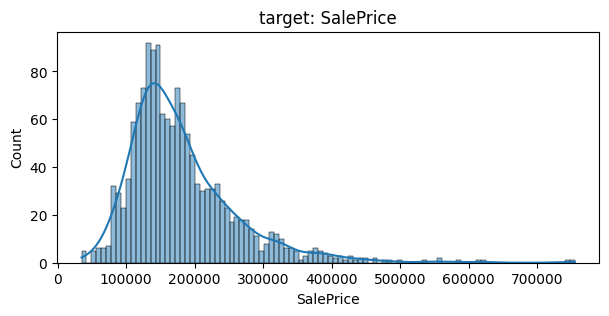

In [3]:
# targetの確認(trainにしかないcolumn)
print(set(train_df.columns) - set(test_df.columns))

print(cfg.target)


fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(
    train_df[cfg.target],
    bins=100,
    kde=True,
    ax=ax,
)
ax.set_title(f"target: {cfg.target}")
ax.set_xlabel(cfg.target)


In [4]:
categorical_columns = []

for col in train_df.columns:
    if train_df[col].dtype == pl.Utf8:
        categorical_columns.append(col)

print(f"categorical_columns: {categorical_columns}")


for col in categorical_columns:
    train_df = train_df.with_columns(pl.col(col).cast(pl.Categorical))


categorical_columns: ['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
train_df = train_df.to_pandas()
test_df = test_df.to_pandas()
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [6]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold


def lightgbm_training(
    train_df: pd.DataFrame,
    target_col: str,
    features: list[str],
    categorical_features: list[str] | None = None,
    lgb_params: dict | None = None,
    n_splits: int = 5,
    num_boost_round: int = 1000,
    stopping_rounds: int = 10,
    log_period: int = 100,
) -> tuple[np.ndarray, list[lgb.Booster]]:  # OOF(log), models
    if lgb_params is None:
        current_params = {  # 元のパラメータを想定
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.1,
            "num_leaves": 31,
            "seed": 42,
            "verbose": -1,
            "boosting_type": "gbdt",
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
        }
    else:
        current_params = lgb_params.copy()

    callbacks = [
        lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=False),
        lgb.log_evaluation(period=log_period),
    ]

    if categorical_features is None:
        categorical_features = []

    X = train_df[features]
    y_log = np.log1p(train_df[target_col]).to_numpy()

    oof_preds_log = np.zeros(len(train_df))
    models = []
    fold_metrics_log = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X, y_log)):
        print(f"--- LightGBM Fold {fold + 1}/{n_splits} ---")
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_log, y_va_log = y_log[tr_idx], y_log[va_idx]

        train_data = lgb.Dataset(X_tr, label=y_tr_log, categorical_feature=categorical_features)
        valid_data = lgb.Dataset(X_va, label=y_va_log, categorical_feature=categorical_features, reference=train_data)

        model = lgb.train(
            params=current_params,
            train_set=train_data,
            num_boost_round=num_boost_round,
            valid_sets=[train_data, valid_data],
            valid_names=["train", "valid"],
            callbacks=callbacks,
        )

        fold_pred_log = model.predict(X_va)
        oof_preds_log[va_idx] = fold_pred_log
        models.append(model)

        metric_val_log = root_mean_squared_error(y_va_log, fold_pred_log)
        print(f"Fold {fold + 1} RMSE (log scale): {metric_val_log:.4f}")
        fold_metrics_log.append(metric_val_log)

    mean_cv_metric_log = np.mean(fold_metrics_log)
    std_cv_metric_log = np.std(fold_metrics_log)
    print(f"\nMean CV RMSE (log scale): {mean_cv_metric_log:.4f} (std: {std_cv_metric_log:.4f})")

    oof_rmse_log = root_mean_squared_error(y_log, oof_preds_log)
    print(f"Overall OOF RMSE (log scale): {oof_rmse_log:.4f}")

    return oof_preds_log, models  # ★対数スケールのOOFを返す


def lightgbm_inference(models: list[lgb.Booster], test_df: pd.DataFrame, features: list[str]) -> np.ndarray:
    X_test = test_df[features]
    all_preds_log = []
    for _, model in enumerate(models):
        pred_log = model.predict(X_test)
        all_preds_log.append(pred_log)
    predictions_array_log = np.array(all_preds_log)
    mean_predictions_log = np.mean(predictions_array_log, axis=0)
    return mean_predictions_log  # ★対数スケールの予測値を返す


In [10]:
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "seed": 42,
    "verbose": -1,
    "boosting_type": "gbdt",
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
}

# OOF予測値は対数スケールで受け取る
oof_log, models = lightgbm_training(
    train_df,  # split後のtrain_df
    target_col=cfg.target,
    features=[col for col in train_df.columns if col != cfg.target],
    categorical_features=categorical_columns,
    lgb_params=lgb_params,
)


--- LightGBM Fold 1/5 ---
Fold 1 RMSE (log scale): 0.1344
--- LightGBM Fold 2/5 ---
Fold 2 RMSE (log scale): 0.1284
--- LightGBM Fold 3/5 ---
Fold 3 RMSE (log scale): 0.1602
--- LightGBM Fold 4/5 ---
Fold 4 RMSE (log scale): 0.1192
--- LightGBM Fold 5/5 ---
Fold 5 RMSE (log scale): 0.1068

Mean CV RMSE (log scale): 0.1298 (std: 0.0178)
Overall OOF RMSE (log scale): 0.1311


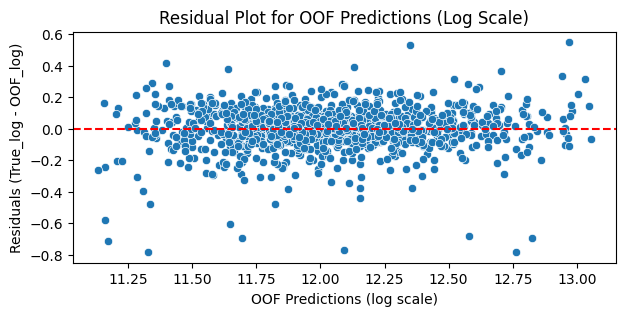

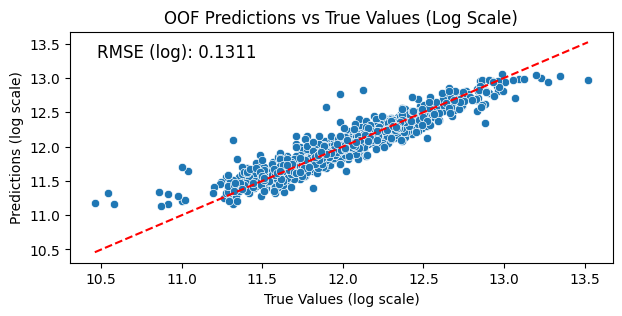

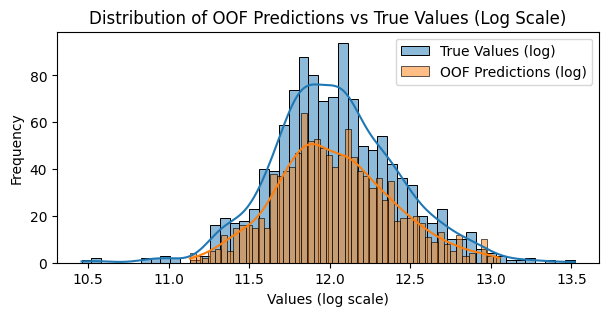

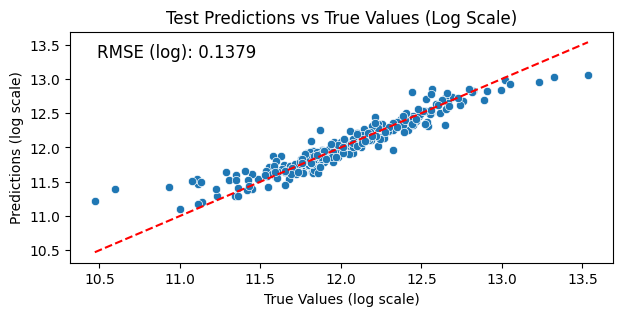

In [11]:
# 推論 (結果は対数スケール)
y_pred_log = lightgbm_inference(
    models,
    test_df,  # split後のtest_df
    features=[col for col in test_df.columns if col != cfg.target],
)

# OOF残差プロット (対数スケールで計算・表示)
residuals_oof_log = np.log1p(train_df[cfg.target]) - oof_log
fig, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x=oof_log, y=residuals_oof_log, ax=ax)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("OOF Predictions (log scale)")
ax.set_ylabel("Residuals (True_log - OOF_log)")
ax.set_title("Residual Plot for OOF Predictions (Log Scale)")
plt.show()

# OOF散布図 (対数スケールで計算・表示)
fig, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x=np.log1p(train_df[cfg.target]), y=oof_log, ax=ax)
ax.set_xlabel("True Values (log scale)")
ax.set_ylabel("Predictions (log scale)")
ax.set_title("OOF Predictions vs True Values (Log Scale)")
log_true_min = np.log1p(train_df[cfg.target]).min()
log_true_max = np.log1p(train_df[cfg.target]).max()
plt.plot([log_true_min, log_true_max], [log_true_min, log_true_max], "r--")
oof_rmse_log = root_mean_squared_error(np.log1p(train_df[cfg.target]), oof_log)
ax.text(0.05, 0.95, f"RMSE (log): {oof_rmse_log:.4f}", ha="left", va="top", transform=ax.transAxes, fontsize=12)
plt.show()

# OOFヒストグラム (対数スケールで表示)
fig, ax = plt.subplots(figsize=(7, 3))
sns.histplot(np.log1p(train_df[cfg.target]), bins=50, kde=True, ax=ax, label="True Values (log)")
sns.histplot(oof_log, bins=50, kde=True, ax=ax, label="OOF Predictions (log)")
ax.set_xlabel("Values (log scale)")
ax.set_ylabel("Frequency")
ax.legend()
ax.set_title("Distribution of OOF Predictions vs True Values (Log Scale)")
plt.show()

# test予測値と真値の比較 (散布図、対数スケールで計算・表示)

fig, ax = plt.subplots(figsize=(7, 3))
sns.scatterplot(x=np.log1p(test_df[cfg.target]), y=y_pred_log, ax=ax)
ax.set_xlabel("True Values (log scale)")
ax.set_ylabel("Predictions (log scale)")
ax.set_title("Test Predictions vs True Values (Log Scale)")
log_true_test_min = np.log1p(test_df[cfg.target]).min()
log_true_test_max = np.log1p(test_df[cfg.target]).max()
plt.plot([log_true_test_min, log_true_test_max], [log_true_test_min, log_true_test_max], "r--")
test_rmse_log = root_mean_squared_error(np.log1p(test_df[cfg.target]), y_pred_log)
ax.text(0.05, 0.95, f"RMSE (log): {test_rmse_log:.4f}", ha="left", va="top", transform=ax.transAxes, fontsize=12)
plt.show()


In [13]:
# 全データ学習
train_df = pl.read_csv(cfg.data.train_path, infer_schema_length=10_000)
train_schema = train_df.schema

test_df = pl.read_csv(
    cfg.data.test_path,
    dtypes=train_schema,  # train_dfから取得したスキーマを適用
    null_values=["null", "NULL", "NaN", "NAN", "nan", "NAN", "NaN", "NA"],
)

categorical_columns = []
for col in train_df.columns:
    if train_df[col].dtype == pl.Utf8:
        categorical_columns.append(col)

for col in categorical_columns:
    train_df = train_df.with_columns(pl.col(col).cast(pl.Categorical))
    test_df = test_df.with_columns(pl.col(col).cast(pl.Categorical))

train_df = train_df.to_pandas()
test_df = test_df.to_pandas()
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


/var/folders/w4/sbs2f2cj56sbzcv2jqz2q_j80000gn/T/ipykernel_93047/245340651.py:5: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  test_df = pl.read_csv(


In [14]:
# 全データで学習 (oof_logは対数スケール)
oof_log, models = lightgbm_training(
    train_df,  # 全データ
    target_col=cfg.target,
    features=[col for col in train_df.columns if col != cfg.target],
    categorical_features=categorical_columns,
    lgb_params=lgb_params,
    n_splits=cfg.n_splits,
)

# テストデータで推論 (y_pred_logは対数スケール)
y_pred_log = lightgbm_inference(
    models,
    test_df,  # コンペのテストデータ
    features=[col for col in test_df.columns if col != cfg.target],
)

# 提出用ファイルの作成
sub = pd.read_csv(cfg.data.sample_submission_path)

# ★予測値を元のスケールに戻す
sub[cfg.target] = np.expm1(y_pred_log)
sub[cfg.target] = sub[cfg.target].clip(0)  # 念のため

Path(cfg.data.results_dir).mkdir(parents=True, exist_ok=True)
sub.to_csv(Path(cfg.data.results_dir) / f"submission_{cfg.exp_number}.csv", index=False)
print(f"Submission file created at: {Path(cfg.data.results_dir) / f'submission_{cfg.exp_number}.csv'}")


--- LightGBM Fold 1/5 ---
Fold 1 RMSE (log scale): 0.1384
--- LightGBM Fold 2/5 ---
Fold 2 RMSE (log scale): 0.1166
--- LightGBM Fold 3/5 ---
Fold 3 RMSE (log scale): 0.1504
--- LightGBM Fold 4/5 ---
[100]	train's rmse: 0.042218	valid's rmse: 0.129398
Fold 4 RMSE (log scale): 0.1283
--- LightGBM Fold 5/5 ---
Fold 5 RMSE (log scale): 0.1198

Mean CV RMSE (log scale): 0.1307 (std: 0.0124)
Overall OOF RMSE (log scale): 0.1313
Submission file created at: ../../results/000/submission_000.csv
